<a href="https://colab.research.google.com/github/zxtine/kmsg_project/blob/main/kmsg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-Assisted Donor Matching Tool (Early-Stage Demo)
## ProPublica Nonprofit Explorer API + IRS/TEOS “All Years” Pathway

**Purpose (client demo):**
1) Prove we can discover and pull a large universe of Pennsylvania (PA) organizations and their filings  
2) Build a clean, model-ready dataset with safe derived financial features  
3) Run prioritization-focused EDA so we can decide which foundations to focus on first  
4) Demonstrate a future-proof IRS/TEOS pathway that can scale across years even if we only process a sample today  

**Key design principles:**
- Fast “sample mode” for demos, easily expandable to “all”
- Deterministic, reproducible outputs (raw JSON caching, non-destructive writes)
- Frequent EDA prints after each major transformation (client-friendly narrative)
- Robust error handling: retries/backoff, polite rate limiting, failure logs



In [32]:
# Imports + Global Settings

from __future__ import annotations

import os
import re
import json
import time
import math
import random
import warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

warnings.filterwarnings("default")


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Section 1. Configuration

This notebook is intentionally configurable for:
- **Discovery** (ProPublica search parameters)
- **Fetch performance** (sample vs all, max EINs, caching, rate limiting)
- **IRS/TEOS years** (range string like `2022-2025`)

We keep variables consistent end-to-end and avoid silent overwrites.


In [44]:
# 1. Config Knobs (Performance + Discovery + Paths)

# =========================
# 1A) Core performance knobs
# =========================
FETCH_MODE = "sample"  # "sample" or "all"
MAX_EINS_TO_FETCH = 500  # used in sample mode; ignored in "all" unless you keep it as a safety cap
SAMPLE_STRATEGY = "top_assets_then_random"  # "random" | "top_assets_then_random" | "first_n"

# =========================
# 1B) ProPublica discovery knobs (STRUCTURED SEARCH — required)
# =========================
PROPUBLICA_BASE = "https://projects.propublica.org/nonprofits/api/v2"
PROPUBLICA_SEARCH_URL = f"{PROPUBLICA_BASE}/search.json"
PROPUBLICA_ORG_URL = f"{PROPUBLICA_BASE}/organizations/{{ein}}.json"

STATE_ID = "PA"

# c_code[id] is the subsection code for 501(c)(___). For 501(c)(3), use 3.
# Keep it configurable because you may want private foundations vs broader nonprofit universe later.
C_CODE_ID: Optional[int] = 3  # set to None to not filter

# ntee[id] is the NCCS "major group" integer 1-10. Set None to not filter.
NTEE_MAJOR_ID: Optional[int] = None

# How many pages to scan (ProPublica is 25 results/page as of their docs)
MAX_SEARCH_PAGES = 50  # increase later for bigger universes

# =========================
# 1C) Fetch behavior + politeness
# =========================
REQUEST_TIMEOUT_SEC = 20
PER_REQUEST_SLEEP_SEC = 0.15      # polite base delay
RETRY_TOTAL = 6
RETRY_BACKOFF_FACTOR = 0.8        # exponential backoff baseline
STATUS_FORCE_LIST = (429, 500, 502, 503, 504)

USER_AGENT = "CMU-Heinz-DonorMatching-Demo/1.0 (contact: team@example.com)"

# =========================
# 1D) Output paths (non-destructive)
# =========================
ROOT_DIR = Path(".")
RAW_DIR = ROOT_DIR / "raw"
OUT_DIR = ROOT_DIR / "outputs"
LOG_DIR = ROOT_DIR / "logs"

RAW_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

ORG_TABLE_PATH = OUT_DIR / "organizations.csv"
FILINGS_TABLE_PATH = OUT_DIR / "filings.csv"
PRIORITY_TABLE_PATH = OUT_DIR / "priority_shortlist.csv"

FAILED_EINS_LOG_PATH = LOG_DIR / "failed_eins.csv"
REQUEST_LOG_PATH = LOG_DIR / "request_log.csv"

print("Config loaded.")
print(f"FETCH_MODE={FETCH_MODE}, MAX_EINS_TO_FETCH={MAX_EINS_TO_FETCH}, SAMPLE_STRATEGY={SAMPLE_STRATEGY}")
print(f"Discovery: STATE_ID={STATE_ID}, C_CODE_ID={C_CODE_ID}, NTEE_MAJOR_ID={NTEE_MAJOR_ID}, MAX_SEARCH_PAGES={MAX_SEARCH_PAGES}")
print(f"Paths: RAW_DIR={RAW_DIR.resolve()}, OUT_DIR={OUT_DIR.resolve()}, LOG_DIR={LOG_DIR.resolve()}")


Config loaded.
FETCH_MODE=sample, MAX_EINS_TO_FETCH=500, SAMPLE_STRATEGY=top_assets_then_random
Discovery: STATE_ID=PA, C_CODE_ID=3, NTEE_MAJOR_ID=None, MAX_SEARCH_PAGES=50
Paths: RAW_DIR=/content/raw, OUT_DIR=/content/outputs, LOG_DIR=/content/logs


# Section 2. HTTP: Single Retry Session (Used Everywhere)

We use one session with retries/backoff for **both ProPublica and IRS calls**.
This keeps behavior consistent and reduces copy/paste bugs.


In [45]:
# 2. Create a Single Retry Session

def make_retry_session() -> requests.Session:
    session = requests.Session()
    session.headers.update({"User-Agent": USER_AGENT})

    retry = Retry(
        total=RETRY_TOTAL,
        backoff_factor=RETRY_BACKOFF_FACTOR,
        status_forcelist=list(STATUS_FORCE_LIST),
        allowed_methods=["GET"],
        raise_on_status=False,
        respect_retry_after_header=True,
    )

    adapter = HTTPAdapter(max_retries=retry, pool_connections=50, pool_maxsize=50)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    return session

session = make_retry_session()
print("Retry session ready.")


Retry session ready.


# Section 3. Helpers: Safe Parsing, Logging, and Non-Destructive Writes

We will:
- Normalize EINs consistently
- Cache raw org JSON per EIN to disk (never refetch if present)
- Log failures with reasons
- Track total request counts for transparency in demos


In [46]:
# 3. Helper Functions (EIN, safe gets, logging)

EIN_RE = re.compile(r"\D+")

def clean_ein(ein: Any) -> str:
    """Return digits-only EIN. Empty string if invalid."""
    if ein is None:
        return ""
    s = str(ein).strip()
    s = EIN_RE.sub("", s)
    return s

def safe_float(x: Any) -> Optional[float]:
    if x is None:
        return None
    try:
        # Avoid treating "" as 0
        if isinstance(x, str) and not x.strip():
            return None
        return float(x)
    except Exception:
        return None

def safe_int(x: Any) -> Optional[int]:
    if x is None:
        return None
    try:
        if isinstance(x, str) and not x.strip():
            return None
        return int(float(x))
    except Exception:
        return None

def ensure_parent_dir(path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)

def write_csv_non_destructive(df: pd.DataFrame, path: Path) -> Path:
    """
    Never silently overwrite. If file exists, create a versioned name.
    Returns the actual path written.
    """
    ensure_parent_dir(path)
    if not path.exists():
        df.to_csv(path, index=False)
        return path

    stem = path.stem
    suffix = path.suffix
    for i in range(1, 1000):
        candidate = path.parent / f"{stem}_v{i}{suffix}"
        if not candidate.exists():
            df.to_csv(candidate, index=False)
            return candidate

    raise RuntimeError(f"Could not find a non-existing versioned filename for {path}")

# Request logging
request_log: List[Dict[str, Any]] = []
failed_eins: List[Dict[str, Any]] = []

def log_request(url: str, status_code: Optional[int], ok: bool, note: str = "") -> None:
    request_log.append({
        "ts_utc": pd.Timestamp.utcnow().isoformat(),
        "url": url,
        "status_code": status_code,
        "ok": ok,
        "note": note,
    })

def log_failed_ein(ein: str, stage: str, reason: str, url: str = "") -> None:
    failed_eins.append({
        "ein": ein,
        "stage": stage,
        "reason": reason,
        "url": url,
        "ts_utc": pd.Timestamp.utcnow().isoformat(),
    })


# Section 4. ProPublica Discovery (PA Organizations)

**Critical requirement:** Do **not** use `q=foundation` then filter to PA.

We will use ProPublica’s **structured search** endpoint:
- paginate pages (`page` is zero-indexed)
- filter with `state[id]=PA`
- optional `c_code[id]` and `ntee[id]`

Output:
- a discovery table `discovered_orgs_df` (one row per organization result)
- a list of candidate EINs to fetch (sample-mode or all-mode)


In [47]:
# 4A. Structured Search (paginate + state[id]=PA + optional filters)

def propublica_search_page(
    session: requests.Session,
    page: int,
    state_id: str,
    c_code_id: Optional[int],
    ntee_major_id: Optional[int],
    timeout_sec: int = REQUEST_TIMEOUT_SEC,
) -> Dict[str, Any]:
    params = {
        "page": page,
        "state[id]": state_id,
    }
    if c_code_id is not None:
        params["c_code[id]"] = int(c_code_id)
    if ntee_major_id is not None:
        params["ntee[id]"] = int(ntee_major_id)

    url = PROPUBLICA_SEARCH_URL
    try:
        resp = session.get(url, params=params, timeout=timeout_sec)
        log_request(resp.url, resp.status_code, resp.ok, note="search_page")
        if resp.status_code != 200:
            return {"_error": f"HTTP {resp.status_code}", "_url": resp.url}
        return resp.json()
    except Exception as e:
        log_request(url, None, False, note=f"search_page_exception: {e}")
        return {"_error": str(e), "_url": url}

def discover_pa_organizations(
    session: requests.Session,
    max_pages: int,
    state_id: str,
    c_code_id: Optional[int],
    ntee_major_id: Optional[int],
) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    meta_summary = {}

    for page in range(max_pages):
        time.sleep(PER_REQUEST_SLEEP_SEC)
        data = propublica_search_page(
            session=session,
            page=page,
            state_id=state_id,
            c_code_id=c_code_id,
            ntee_major_id=ntee_major_id,
        )

        if "_error" in data:
            print(f"[WARN] Search page {page} error: {data.get('_error')} ({data.get('_url')})")
            continue

        # ProPublica search returns a list of "organizations"
        orgs = data.get("organizations") or []
        if page == 0:
            meta_summary = {
                "total_results": data.get("total_results"),
                "num_pages": data.get("num_pages"),
                "per_page": data.get("per_page"),
                "selected_state": data.get("selected_state"),
                "selected_code": data.get("selected_code"),
                "selected_ntee": data.get("selected_ntee"),
            }

        if not orgs:
            print(f"[INFO] No orgs returned on page {page}. Stopping pagination.")
            break

        for o in orgs:
            # Search results are "Organization objects"
            ein = clean_ein(o.get("ein"))
            if not ein:
                continue
            rows.append({
                "ein": ein,
                "name": o.get("name"),
                "city": o.get("city"),
                "state": o.get("state"),
                "subseccd": o.get("subseccd"),
                "ntee_code": o.get("ntee_code"),
                "c_code": o.get("subseccd"),  # kept for readability; ProPublica uses subseccd on org
                "raw_org_obj": o,             # keep raw for reproducibility/debugging
            })

        # If ProPublica says there are fewer pages than we requested, we can stop early
        try:
            num_pages = int(data.get("num_pages") or 0)
            if num_pages and page >= (num_pages - 1):
                break
        except Exception:
            pass

    df = pd.DataFrame(rows).drop_duplicates(subset=["ein"]).reset_index(drop=True)

    print("Discovery meta (page 0):", meta_summary)
    print(f"Discovered organizations: {len(df):,} unique EINs (state={state_id}, c_code={c_code_id}, ntee={ntee_major_id})")
    return df

discovered_orgs_df = discover_pa_organizations(
    session=session,
    max_pages=MAX_SEARCH_PAGES,
    state_id=STATE_ID,
    c_code_id=C_CODE_ID,
    ntee_major_id=NTEE_MAJOR_ID,
)

# EDA print (client-friendly)
display(discovered_orgs_df.head(10))
print(discovered_orgs_df[["state"]].value_counts().head(10))


Discovery meta (page 0): {'total_results': 10000, 'num_pages': 400, 'per_page': 25, 'selected_state': 'PA', 'selected_code': '3', 'selected_ntee': None}
Discovered organizations: 1,250 unique EINs (state=PA, c_code=3, ntee=None)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,ein,name,city,state,subseccd,ntee_code,c_code,raw_org_obj
0,208295721,Upmc,Pittsburgh,PA,3,None,3,"{'ein': 208295721, 'strein': '20-8295721', 'na..."
1,237825575,National Philanthropic Trust,Jenkintown,PA,3,T500,3,"{'ein': 237825575, 'strein': '23-7825575', 'na..."
2,231352685,Trustees Of The University Of Pennsylvania,Philadelphia,PA,3,B430,3,"{'ein': 231352685, 'strein': '23-1352685', 'na..."
3,232888152,Vanguard Charitable Endowment Program,Malvern,PA,3,T700,3,"{'ein': 232888152, 'strein': '23-2888152', 'na..."
4,821406555,Highmark Health,Pittsburgh,PA,3,None,3,"{'ein': 821406555, 'strein': '82-1406555', 'na..."
5,231352166,The Childrens Hospital Of Philadelphia,Philadelphia,PA,3,E240,3,"{'ein': 231352166, 'strein': '23-1352166', 'na..."
6,250965591,University Of Pittsburgh,Pittsburgh,PA,3,B99,3,"{'ein': 250965591, 'strein': '25-0965591', 'na..."
7,231689692,Lehigh Valley Hospital,Allentown,PA,3,E220,3,"{'ein': 231689692, 'strein': '23-1689692', 'na..."
8,251854772,Miltons S Hershey Medical Center,Hershey,PA,3,E20,3,"{'ein': 251854772, 'strein': '25-1854772', 'na..."
9,232829095,Thomas Jefferson University Hospital,Philadelphia,PA,3,E200,3,"{'ein': 232829095, 'strein': '23-2829095', 'na..."


state
PA       1250
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [48]:
# 4B. Self-check: discovery should return "many" PA orgs (not 1)

if len(discovered_orgs_df) <= 1:
    print("[CRITICAL WARN] Discovery returned <= 1 org. This usually indicates the wrong discovery strategy or overly restrictive filters.")
    print("Check: STATE_ID, C_CODE_ID, NTEE_MAJOR_ID, MAX_SEARCH_PAGES.")
else:
    print("[OK] Discovery returned more than 1 organization. This meets the demo requirement.")


[OK] Discovery returned more than 1 organization. This meets the demo requirement.


In [89]:
# Section 4C. Source Schema Inventory (IRS)
# =========================
# SCHEMA INVENTORY 1: ProPublica Search + IRS Index
# Place: right after discovery self-check, before fetching EINs
# =========================

from collections import Counter

def union_keys(dicts: List[Dict[str, Any]]) -> List[str]:
    keys = set()
    for d in dicts:
        if isinstance(d, dict):
            keys.update(d.keys())
    return sorted(keys)

# --- ProPublica Search schema ---
sample_search_objs = discovered_orgs_df["raw_org_obj"].dropna().head(50).tolist()
search_keys = union_keys(sample_search_objs)

print("=== ProPublica SEARCH result keys (union across first 50) ===")
print(search_keys)

# Frequency of keys (helps you see which are common vs rare)
key_counts = Counter()
for o in sample_search_objs:
    if isinstance(o, dict):
        key_counts.update(o.keys())

search_key_freq = pd.DataFrame({
    "key": list(key_counts.keys()),
    "count_in_sample": list(key_counts.values())
}).sort_values("count_in_sample", ascending=False)

display(search_key_freq.head(30))

# --- IRS index schema (if already loaded later, show columns; otherwise skip safely) ---
try:
    print("\n=== IRS INDEX columns (irs_index_df) ===")
    print(list(irs_index_df.columns))
except Exception:
    print("\nIRS index not loaded yet (expected if IRS section is later).")


=== ProPublica SEARCH result keys (union across first 50) ===
['city', 'ein', 'has_subseccd', 'have_extracts', 'have_filings', 'have_pdfs', 'name', 'ntee_code', 'raw_ntee_code', 'score', 'state', 'strein', 'sub_name', 'subseccd']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,key,count_in_sample
0,ein,50
1,strein,50
2,name,50
3,sub_name,50
4,city,50
5,state,50
6,ntee_code,50
7,raw_ntee_code,50
8,subseccd,50
9,has_subseccd,50



=== IRS INDEX columns (irs_index_df) ===
['RETURN_ID', 'FILING_TYPE', 'EIN', 'TAX_PERIOD', 'SUB_DATE', 'TAXPAYER_NAME', 'RETURN_TYPE', 'DLN', 'OBJECT_ID', 'XML_BATCH_ID', 'index_year']


# Section 4D. Early Geography Preview (PA Discovery Universe)

Before sampling, we can map the *discovered* PA org universe using offline ZIP → lat/lon.
This is useful for a client demo to show coverage and geographic concentration.


In [97]:
# 7A-Geo Map using organizations_df ZIPs (recommended — higher coverage)

!pip -q install pgeocode folium
import pgeocode, folium, math
from folium.plugins import MarkerCluster

nomi = pgeocode.Nominatim("US")

org_geo = organizations_df[["ein", "org_name", "org_city", "org_state", "zipcode"]].copy()
org_geo["zip5"] = org_geo["zipcode"].astype(str).str.extract(r"(\d{5})", expand=False)

zip_series = org_geo["zip5"].fillna("").astype(str).tolist()
zip_geo = nomi.query_postal_code(zip_series)

org_geo["lat"] = zip_geo["latitude"].values
org_geo["lon"] = zip_geo["longitude"].values

org_geo_map = org_geo.dropna(subset=["lat", "lon"]).copy()
print("Geocoded org rows:", len(org_geo_map), "out of", len(org_geo))
display(org_geo_map.head(10))

m = folium.Map(location=[40.44, -79.99], zoom_start=7)
cluster = MarkerCluster().add_to(m)

for _, r in org_geo_map.iterrows():
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=3,
        popup=f'{r["org_name"]} (EIN {r["ein"]})',
        fill=True,
    ).add_to(cluster)

m


Geocoded org rows: 500 out of 500


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,ein,org_name,org_city,org_state,zipcode,zip5,lat,lon
0,474229584,Kipp Dubois Charter School,Philadelphia,PA,19131-4747,19131,39.9845,-75.2282
1,231715152,Walnut Street Theatre Corp,Philadelphia,PA,19107-5107,19107,39.9487,-75.1593
2,233073983,Philadelphia Electrical And Technology Charter...,Philadelphia,PA,19103-1206,19103,39.9513,-75.1741
3,250987225,Family Services Of Nw Pa,Erie,PA,16509-2482,16509,42.0763,-80.0668
4,232043478,Berks Counseling Center Inc,Reading,PA,19601-3543,19601,40.3466,-75.9351
5,812911777,Global Leadership Academy Southwest Charter Sc...,Philadelphia,PA,19143-1521,19143,39.9448,-75.2288
6,232450112,Planned Parenthood Keystone,Allentown,PA,18101-1102,18101,40.6026,-75.4691
7,232378625,Friends Life Care,Blue Bell,PA,19422-2323,19422,40.1576,-75.2799
8,232890364,Scranton Area Foundation Inc,Scranton,PA,18510-1622,18510,41.4080,-75.6484
9,251605062,H A P Enterprises Inc,Beaver,PA,15009-3032,15009,40.6972,-80.3365


# Section 5.  

We support:
- `FETCH_MODE="sample"`: fetch a limited set of EINs quickly (client demos)
- `FETCH_MODE="all"`: fetch everything discovered (use with care)

Sample strategies:
- `random`: random EINs
- `first_n`: deterministic first N
- `top_assets_then_random`: prioritize orgs likely to have data by using whatever summary fields exist (light heuristic), then fill remainder randomly


In [50]:
# 5. Choose EINs to Fetch (Sample vs All)

def choose_eins_to_fetch(
    discovered_df: pd.DataFrame,
    fetch_mode: str,
    max_eins: int,
    strategy: str,
) -> List[str]:
    all_eins = discovered_df["ein"].dropna().astype(str).tolist()

    if fetch_mode.lower() == "all":
        print(f"[INFO] FETCH_MODE=all → selecting all discovered EINs: {len(all_eins):,}")
        return all_eins

    # Sample mode
    max_eins = min(max_eins, len(all_eins))
    print(f"[INFO] FETCH_MODE=sample → selecting {max_eins:,} EINs (strategy={strategy})")

    if strategy == "first_n":
        return all_eins[:max_eins]

    if strategy == "random":
        return random.sample(all_eins, k=max_eins)

    if strategy == "top_assets_then_random":
        # In search results, we do not get financials. So this is a light heuristic:
        # - prefer entries that have ntee_code + subseccd populated (more complete metadata)
        # - then randomly fill remaining
        tmp = discovered_df.copy()
        tmp["meta_completeness"] = (
            tmp["ntee_code"].notna().astype(int) +
            tmp["subseccd"].notna().astype(int) +
            tmp["city"].notna().astype(int)
        )
        tmp = tmp.sort_values(["meta_completeness"], ascending=False)
        top = tmp["ein"].head(max_eins).astype(str).tolist()

        # If for some reason we got fewer than max_eins (should not happen), fill randomly
        if len(top) < max_eins:
            remaining = [e for e in all_eins if e not in set(top)]
            fill = random.sample(remaining, k=(max_eins - len(top)))
            top.extend(fill)
        return top

    raise ValueError(f"Unknown SAMPLE_STRATEGY: {strategy}")

candidate_eins = choose_eins_to_fetch(
    discovered_df=discovered_orgs_df,
    fetch_mode=FETCH_MODE,
    max_eins=MAX_EINS_TO_FETCH,
    strategy=SAMPLE_STRATEGY,
)

print(f"Candidate EINs selected: {len(candidate_eins):,}")
print("Example EINs:", candidate_eins[:10])


[INFO] FETCH_MODE=sample → selecting 500 EINs (strategy=top_assets_then_random)
Candidate EINs selected: 500
Example EINs: ['474229584', '231715152', '233073983', '250987225', '232043478', '812911777', '232450112', '232378625', '232890364', '251605062']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Section 6. Fetch Org JSON per EIN (Cached + Retry/Backoff + Failure Logs)

This is the section that was too slow. Fixes included:
- `FETCH_MODE` + `MAX_EINS_TO_FETCH`
- Disk caching: `raw/org_<ein>.json` (skip if exists)
- Polite sleep + retry/backoff via session
- Clear failure logging + request counts


In [51]:
# 6A. Fetch & Cache Org JSON per EIN (no refetch if cached)

def org_json_path(ein: str) -> Path:
    return RAW_DIR / f"org_{ein}.json"

def fetch_propublica_org_json(
    session: requests.Session,
    ein: str,
    timeout_sec: int = REQUEST_TIMEOUT_SEC,
) -> Optional[Dict[str, Any]]:
    ein_clean = clean_ein(ein)
    if not ein_clean:
        log_failed_ein(ein=str(ein), stage="fetch_org", reason="invalid_ein")
        return None

    url = PROPUBLICA_ORG_URL.format(ein=ein_clean)
    try:
        resp = session.get(url, timeout=timeout_sec)
        log_request(resp.url, resp.status_code, resp.ok, note="org_json")
        if resp.status_code != 200:
            log_failed_ein(ein_clean, "fetch_org", f"http_{resp.status_code}", url=resp.url)
            return None

        data = resp.json()
        if not isinstance(data, dict):
            log_failed_ein(ein_clean, "fetch_org", "unexpected_json_schema_not_dict", url=resp.url)
            return None
        return data

    except Exception as e:
        log_failed_ein(ein_clean, "fetch_org", f"exception: {e}", url=url)
        return None

def get_org_json_cached(
    session: requests.Session,
    ein: str,
    sleep_sec: float = PER_REQUEST_SLEEP_SEC,
) -> Optional[Dict[str, Any]]:
    ein_clean = clean_ein(ein)
    path = org_json_path(ein_clean)

    if path.exists():
        try:
            with path.open("r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            # Cache exists but is unreadable → refetch once
            log_failed_ein(ein_clean, "read_cache", f"cache_read_error: {e}", url=str(path))

    # Not cached (or unreadable) → fetch
    time.sleep(sleep_sec)
    data = fetch_propublica_org_json(session=session, ein=ein_clean)
    if data is None:
        return None

    # Write raw JSON non-destructively: path is EIN-specific, so safe to overwrite only if we choose to.
    # We will still avoid silent overwrites by checking if file exists and size > 0.
    if path.exists() and path.stat().st_size > 0:
        # If it exists, do not overwrite silently; write a versioned cache file
        versioned = RAW_DIR / f"org_{ein_clean}_v{int(time.time())}.json"
        with versioned.open("w", encoding="utf-8") as f:
            json.dump(data, f)
    else:
        with path.open("w", encoding="utf-8") as f:
            json.dump(data, f)

    return data

# Fetch loop
org_json_by_ein: Dict[str, Dict[str, Any]] = {}
start = time.time()

for i, ein in enumerate(candidate_eins, 1):
    ein_clean = clean_ein(ein)
    data = get_org_json_cached(session=session, ein=ein_clean)
    if data is not None:
        org_json_by_ein[ein_clean] = data

    if i % 25 == 0:
        elapsed = time.time() - start
        print(f"[Progress] {i:,}/{len(candidate_eins):,} processed | cached+fetched ok: {len(org_json_by_ein):,} | elapsed: {elapsed:,.1f}s")

print(f"Done. Total EINs attempted: {len(candidate_eins):,}; successful org JSON: {len(org_json_by_ein):,}")


[Progress] 25/500 processed | cached+fetched ok: 25 | elapsed: 0.0s
[Progress] 50/500 processed | cached+fetched ok: 50 | elapsed: 0.0s
[Progress] 75/500 processed | cached+fetched ok: 75 | elapsed: 0.0s
[Progress] 100/500 processed | cached+fetched ok: 100 | elapsed: 0.1s
[Progress] 125/500 processed | cached+fetched ok: 125 | elapsed: 0.1s
[Progress] 150/500 processed | cached+fetched ok: 150 | elapsed: 0.1s
[Progress] 175/500 processed | cached+fetched ok: 175 | elapsed: 0.1s
[Progress] 200/500 processed | cached+fetched ok: 200 | elapsed: 0.1s
[Progress] 225/500 processed | cached+fetched ok: 225 | elapsed: 5.3s
[Progress] 250/500 processed | cached+fetched ok: 250 | elapsed: 10.5s
[Progress] 275/500 processed | cached+fetched ok: 275 | elapsed: 16.0s
[Progress] 300/500 processed | cached+fetched ok: 300 | elapsed: 21.4s
[Progress] 325/500 processed | cached+fetched ok: 325 | elapsed: 26.5s
[Progress] 350/500 processed | cached+fetched ok: 350 | elapsed: 34.8s
[Progress] 375/500 pr

In [54]:
# 6B. Persist logs (requests + failed EINs) non-destructively

request_log_df = pd.DataFrame(request_log)
failed_eins_df = pd.DataFrame(failed_eins)

req_written = write_csv_non_destructive(request_log_df, REQUEST_LOG_PATH)
fail_written = write_csv_non_destructive(failed_eins_df, FAILED_EINS_LOG_PATH)

print("Wrote request log to:", req_written)
print("Wrote failed EINs log to:", fail_written)

# EDA prints (client-friendly)
display(request_log_df.tail(10))
display(failed_eins_df.head(20))
print("Failure count:", len(failed_eins_df))


Wrote request log to: logs/request_log_v2.csv
Wrote failed EINs log to: logs/failed_eins_v2.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,ts_utc,url,status_code,ok,note
340,2026-02-13T16:53:25.859948+00:00,https://projects.propublica.org/nonprofits/api...,200,True,org_json
341,2026-02-13T16:53:26.056625+00:00,https://projects.propublica.org/nonprofits/api...,200,True,org_json
342,2026-02-13T16:53:26.262250+00:00,https://projects.propublica.org/nonprofits/api...,200,True,org_json
343,2026-02-13T16:53:26.464265+00:00,https://projects.propublica.org/nonprofits/api...,200,True,org_json
344,2026-02-13T16:53:26.663474+00:00,https://projects.propublica.org/nonprofits/api...,200,True,org_json
345,2026-02-13T16:53:26.855663+00:00,https://projects.propublica.org/nonprofits/api...,200,True,org_json
346,2026-02-13T16:53:27.065060+00:00,https://projects.propublica.org/nonprofits/api...,200,True,org_json
347,2026-02-13T16:53:27.271162+00:00,https://projects.propublica.org/nonprofits/api...,200,True,org_json
348,2026-02-13T16:53:27.468943+00:00,https://projects.propublica.org/nonprofits/api...,200,True,org_json
349,2026-02-13T16:53:27.684182+00:00,https://projects.propublica.org/nonprofits/api...,200,True,org_json


""


Failure count: 0


# Section 7. Build Tables: organizations_df + filings_df + num_df

We now parse cached org JSON into tidy tables:
- `organizations_df`: one row per EIN with core org attributes
- `filings_df`: one row per EIN per filing/tax period (includes PDF URL if present)
- We flatten **all numeric scalar fields** in filings (no tiny hardcoded subset)
- `has_numeric_data` flag

We will print EDA after each build step.


In [55]:
# 7A. Parse organizations_df (1 row per EIN)

ORG_KEEP_FIELDS = [
    "ein", "name", "city", "state", "zipcode",
    "subseccd", "ntee_code", "guidestar_url", "nccs_url",
    "ruling_date", "classification", "deductibility",
    "foundation", "organization", "affiliation", "status",
    "tax_period", "filing_req_cd",
    "acct_pd", "asset_cd", "income_cd",
]

def parse_organization_row(ein: str, data: Dict[str, Any]) -> Dict[str, Any]:
    org = data.get("organization") or {}
    row = {"ein": clean_ein(ein)}

    # Keep curated fields (stable, demo-friendly)
    for k in ORG_KEEP_FIELDS:
        if k == "ein":
            continue
        row[k] = org.get(k)

    # A few helpful standardized names
    row["org_name"] = org.get("name")
    row["org_state"] = org.get("state")
    row["org_city"] = org.get("city")

    return row

org_rows = [parse_organization_row(ein, d) for ein, d in org_json_by_ein.items()]
organizations_df = pd.DataFrame(org_rows).drop_duplicates(subset=["ein"]).reset_index(drop=True)

print(f"organizations_df shape: {organizations_df.shape}")
display(organizations_df.head(10))

# Quick coverage EDA
print("State distribution (top):")
display(organizations_df["org_state"].value_counts().head(10))


organizations_df shape: (500, 24)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,ein,name,city,state,zipcode,subseccd,ntee_code,guidestar_url,nccs_url,ruling_date,classification,deductibility,foundation,organization,affiliation,status,tax_period,filing_req_cd,acct_pd,asset_cd,income_cd,org_name,org_state,org_city
0,474229584,Kipp Dubois Charter School,Philadelphia,PA,19131-4747,None,B29,None,None,2016-02-01,None,None,None,None,None,None,2024-06-01,None,None,None,None,Kipp Dubois Charter School,PA,Philadelphia
1,231715152,Walnut Street Theatre Corp,Philadelphia,PA,19107-5107,None,A650,None,None,1969-10-01,None,None,None,None,None,None,2024-06-01,None,None,None,None,Walnut Street Theatre Corp,PA,Philadelphia
2,233073983,Philadelphia Electrical And Technology Charter...,Philadelphia,PA,19103-1206,None,B25,None,None,2001-08-01,None,None,None,None,None,None,2024-06-01,None,None,None,None,Philadelphia Electrical And Technology Charter...,PA,Philadelphia
3,250987225,Family Services Of Nw Pa,Erie,PA,16509-2482,None,P40Z,None,None,1956-07-01,None,None,None,None,None,None,2024-06-01,None,None,None,None,Family Services Of Nw Pa,PA,Erie
4,232043478,Berks Counseling Center Inc,Reading,PA,19601-3543,None,F22Z,None,None,1979-02-01,None,None,None,None,None,None,2024-06-01,None,None,None,None,Berks Counseling Center Inc,PA,Reading
5,812911777,Global Leadership Academy Southwest Charter Sc...,Philadelphia,PA,19143-1521,None,B29,None,None,2017-02-01,None,None,None,None,None,None,2024-06-01,None,None,None,None,Global Leadership Academy Southwest Charter Sc...,PA,Philadelphia
6,232450112,Planned Parenthood Keystone,Allentown,PA,18101-1102,None,E42,None,None,1990-03-01,None,None,None,None,None,None,2024-06-01,None,None,None,None,Planned Parenthood Keystone,PA,Allentown
7,232378625,Friends Life Care,Blue Bell,PA,19422-2323,None,P44Z,None,None,1987-01-01,None,None,None,None,None,None,2024-12-01,None,None,None,None,Friends Life Care,PA,Blue Bell
8,232890364,Scranton Area Foundation Inc,Scranton,PA,18510-1622,None,T310,None,None,1997-08-01,None,None,None,None,None,None,2024-12-01,None,None,None,None,Scranton Area Foundation Inc,PA,Scranton
9,251605062,H A P Enterprises Inc,Beaver,PA,15009-3032,None,P80Z,None,None,1991-06-01,None,None,None,None,None,None,2024-06-01,None,None,None,None,H A P Enterprises Inc,PA,Beaver


State distribution (top):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,count
org_state,
PA,500


In [57]:
# 7A (continued). Parse filings_df (flatten numeric fields + PDF metadata)

BASE_FILING_FIELDS = ["ein", "tax_prd", "tax_prd_yr", "formtype", "pdf_url", "updated"]

def flatten_numeric_scalars(obj: Dict[str, Any], prefix: str = "") -> Dict[str, Any]:
    """
    Flatten only numeric scalar fields at the top level of a filing object.
    We intentionally avoid deep nesting to keep output stable and model-ready.
    """
    out = {}
    for k, v in (obj or {}).items():
        if isinstance(v, (int, float)) and not isinstance(v, bool):
            out[prefix + k] = v
        elif isinstance(v, str):
            # Sometimes numbers come through as numeric strings
            fv = safe_float(v)
            if fv is not None and re.fullmatch(r"[-+]?\d*\.?\d+", v.strip()):
                out[prefix + k] = fv
    return out

def parse_filing_rows(ein: str, data: Dict[str, Any]) -> List[Dict[str, Any]]:
    rows: List[Dict[str, Any]] = []
    ein_clean = clean_ein(ein)

    filings_with_data = data.get("filings_with_data") or []
    filings_without_data = data.get("filings_without_data") or []

    def build_row(f: Dict[str, Any], has_numeric: bool) -> Dict[str, Any]:
        row = {"ein": ein_clean}

        # Base metadata
        row["tax_prd"] = f.get("tax_prd")
        row["tax_prd_yr"] = f.get("tax_prd_yr")
        row["formtype"] = f.get("formtype")
        row["pdf_url"] = f.get("pdf_url")
        row["updated"] = f.get("updated")

        # Add numeric scalars (broad coverage without hardcoding a tiny subset)
        numeric_flat = flatten_numeric_scalars(f, prefix="fin_")
        row.update(numeric_flat)

        row["has_numeric_data"] = bool(has_numeric and len(numeric_flat) > 0)
        return row

    for f in filings_with_data:
        if isinstance(f, dict):
            rows.append(build_row(f, has_numeric=True))

    for f in filings_without_data:
        if isinstance(f, dict):
            # Without-data filings often only have minimal fields
            rows.append(build_row(f, has_numeric=False))

    return rows

filing_rows: List[Dict[str, Any]] = []
for ein, data in org_json_by_ein.items():
    try:
        filing_rows.extend(parse_filing_rows(ein, data))
    except Exception as e:
        log_failed_ein(clean_ein(ein), "parse_filings", f"exception: {e}")

filings_df = pd.DataFrame(filing_rows)

print(f"filings_df shape: {filings_df.shape}")
display(filings_df.head(10))

# Keep a compatibility alias expected by your edited blocks
num_df = filings_df.copy()

# EDA prints (coverage)
print("Filings count:", len(filings_df))
print("Year range (tax_prd_yr):", filings_df["tax_prd_yr"].min(), "→", filings_df["tax_prd_yr"].max())
print("Formtype distribution:")
display(filings_df["formtype"].value_counts(dropna=False))


filings_df shape: (10331, 193)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,ein,tax_prd,tax_prd_yr,formtype,pdf_url,updated,fin_tax_prd,fin_tax_prd_yr,fin_formtype,fin_totrevenue,fin_totfuncexpns,fin_totassetsend,fin_totliabend,fin_pct_compnsatncurrofcr,fin_subseccd,fin_initiationfees,fin_grsrcptspublicuse,fin_grsincmembers,fin_grsincother,fin_totcntrbgfts,fin_totprgmrevnue,fin_invstmntinc,fin_txexmptbndsproceeds,fin_royaltsinc,fin_grsrntsreal,fin_grsrntsprsnl,fin_rntlexpnsreal,fin_rntlexpnsprsnl,fin_rntlincreal,fin_rntlincprsnl,fin_netrntlinc,fin_grsalesecur,fin_grsalesothr,fin_cstbasisecur,fin_cstbasisothr,fin_gnlsecur,fin_gnlsothr,fin_netgnls,fin_grsincfndrsng,fin_lessdirfndrsng,fin_netincfndrsng,fin_grsincgaming,fin_lessdirgaming,fin_netincgaming,fin_grsalesinvent,fin_lesscstofgoods,fin_netincsales,fin_miscrevtot11e,fin_compnsatncurrofcr,fin_othrsalwages,fin_payrolltx,fin_profndraising,fin_txexmptbndsend,fin_secrdmrtgsend,fin_unsecurednotesend,fin_retainedearnend,fin_totnetassetend,fin_nonpfrea,fin_gftgrntsrcvd170,fin_txrevnuelevied170,fin_srvcsval170,fin_grsinc170,fin_grsrcptsrelated170,fin_totgftgrntrcvd509,fin_grsrcptsadmissn509,fin_txrevnuelevied509,fin_srvcsval509,fin_subtotsuppinc509,fin_totsupp509,fin_ein,has_numeric_data,fin_totcntrbs,fin_prgmservrev,fin_duesassesmnts,fin_othrinvstinc,fin_grsamtsalesastothr,fin_basisalesexpnsothr,fin_gnsaleofastothr,fin_grsrevnuefndrsng,fin_direxpns,fin_grsalesminusret,fin_costgoodsold,fin_grsprft,fin_othrevnue,fin_totrevnue,fin_totexpns,fin_totexcessyr,fin_othrchgsnetassetfnd,fin_totnetassetsend,fin_unrelbusincd,fin_initiationfee,fin_grspublicrcpts,fin_formtype_str,fin_eostatus,fin_tax_yr,fin_subcd,fin_grscontrgifts,fin_intrstrvnue,fin_dividndsamt,fin_totexcapgn,fin_totexcapls,fin_grsprofitbus,fin_otherincamt,fin_compofficers,fin_contrpdpbks,fin_totrcptperbks,fin_totexpnspbks,fin_excessrcpts,fin_totexpnsexempt,fin_netinvstinc,fin_totaxpyr,fin_adjnetinc,fin_invstgovtoblig,fin_invstcorpstk,fin_invstcorpbnd,fin_totinvstsec,fin_fairmrktvalamt,fin_undistribincyr,fin_cmpmininvstret,fin_grsrents,fin_costsold,fin_totrcptnetinc,fin_trcptadjnetinc,fin_topradmnexpnsa,fin_topradmnexpnsb,fin_topradmnexpnsd,fin_totexpnsnetinc,fin_totexpnsadjnet,fin_othrcashamt,fin_mrtgloans,fin_othrinvstend,fin_fairmrktvaleoy,fin_mrtgnotespay,fin_tfundnworth,fin_invstexcisetx,fin_sect511tx,fin_subtitleatx,fin_esttaxcr,fin_txwithldsrc,fin_txpaidf2758,fin_erronbkupwthld,fin_estpnlty,fin_crelamt,fin_tfairmrktunuse,fin_distribamt,fin_adjnetinccola,fin_adjnetinccolb,fin_adjnetinccolc,fin_adjnetinccold,fin_adjnetinctot,fin_qlfydistriba,fin_qlfydistribb,fin_qlfydistribc,fin_qlfydistribd,fin_qlfydistribtot,fin_valassetscola,fin_valassetscolb,fin_valassetscolc,fin_valassetscold,fin_valassetstot,fin_qlfyasseta,fin_qlfyassetb,fin_qlfyassetc,fin_qlfyassetd,fin_qlfyassettot,fin_endwmntscola,fin_endwmntscolb,fin_endwmntscolc,fin_endwmntscold,fin_endwmntstot,fin_totsuprtcola,fin_totsuprtcolb,fin_totsuprtcolc,fin_totsuprtcold,fin_totsuprttot,fin_pubsuprtcola,fin_pubsuprtcolb,fin_pubsuprtcolc,fin_pubsuprtcold,fin_pubsuprttot,fin_grsinvstinca,fin_grsinvstincb,fin_grsinvstincc,fin_grsinvstincd,fin_grsinvstinctot,fin_sec4940notxcd,fin_sec4940redtxcd,fin_assetcdgen,fin_transinccd,fin_balduopt,fin_gftgrntrcvd170,fin_grsrcptsrelatd170,fin_grsrcptsadmiss509
0,474229584,202306,2023,0,None,2025-08-05T16:09:36.290Z,202306,2023,0,11368196.0,11974870.0,11578279.0,9113372.0,0.000,3.0,0.0,0.0,0.0,0.0,2951462.0,8388919.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27802.0,158433.0,4464326.0,377866.0,0.0,0.0,0.0,0.0,0.0,2464907.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,474229584.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Filings count: 10331
Year range (tax_prd_yr): 1998 → 2024
Formtype distribution:


,count
formtype,
0,9987
2,316
1,28


In [58]:
# 7A (EDA). Duplicates + Missingness Summary (key fields)

# Duplicates
dup_ein = filings_df.duplicated(subset=["ein"]).sum()
dup_ein_taxprd = filings_df.duplicated(subset=["ein", "tax_prd"]).sum()
print(f"Duplicates check: EIN-only duplicates = {dup_ein:,} (expected, because multiple filings). EIN+tax_prd duplicates = {dup_ein_taxprd:,}")

# Missingness for key demo fields
KEY_FIELDS_FOR_MISSINGNESS = ["pdf_url", "tax_prd_yr"]  # extend after we map metric fields
missing_basic = filings_df[KEY_FIELDS_FOR_MISSINGNESS].isna().mean().sort_values(ascending=False)
print("Missingness (basic fields):")
display((missing_basic * 100).round(1).to_frame("missing_%"))

# Quick PDF coverage
pdf_cov = filings_df["pdf_url"].notna().mean()
print(f"PDF URL coverage: {pdf_cov*100:.1f}%")


Duplicates check: EIN-only duplicates = 9,831 (expected, because multiple filings). EIN+tax_prd duplicates = 0
Missingness (basic fields):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,missing_%
pdf_url,5.5
tax_prd_yr,0.0


PDF URL coverage: 94.5%


# Section 7B. Latest Filing per EIN + $1M Screen

Your edited blocks expect:
- `ASSET_CANDS, REV_CANDS, EXP_CANDS`
- `pick_first_fin_value(...)`
- `metric_assets, metric_revenue, metric_expenses`
- `latest_df`, `shortlist_df`

Because ProPublica returns many numeric fields depending on form type, we define *candidate column lists* and pick the first available per row.


In [59]:
# 7B. Candidate fields + pick_first_fin_value helper (compatible with your blocks)

# We flattened filing numerics into columns like fin_totalassetsend, fin_totalrevenue, etc.
# Candidate lists are intentionally broad and editable.
ASSET_CANDS = [
    "fin_totassetsend", "fin_totalassetsend", "fin_totalassets",
    "fin_assetsend", "fin_assets", "fin_totassets",
]
LIAB_CANDS = [
    "fin_totliabend", "fin_totalliabilitiesend", "fin_liabend", "fin_liabilities",
]
REV_CANDS = [
    "fin_totrevenue", "fin_totalrevenue", "fin_revenue",
    "fin_totrevnue",  # defensive: occasional misspellings in raw extracts
]
EXP_CANDS = [
    "fin_totexpenses", "fin_totalexpenses", "fin_expenses",
]

def pick_first_fin_value(row: pd.Series, candidates: List[str]) -> Optional[float]:
    """
    Return first non-null, finite numeric value among candidate columns.
    """
    for c in candidates:
        if c in row.index:
            v = row[c]
            fv = safe_float(v)
            if fv is not None and np.isfinite(fv):
                return float(fv)
    return None

# Create metric_* columns expected by your edited blocks
filings_df["metric_assets"] = filings_df.apply(lambda r: pick_first_fin_value(r, ASSET_CANDS), axis=1)
filings_df["metric_liabilities"] = filings_df.apply(lambda r: pick_first_fin_value(r, LIAB_CANDS), axis=1)
filings_df["metric_revenue"] = filings_df.apply(lambda r: pick_first_fin_value(r, REV_CANDS), axis=1)
filings_df["metric_expenses"] = filings_df.apply(lambda r: pick_first_fin_value(r, EXP_CANDS), axis=1)

# EDA print right after transformation (client-friendly)
display(filings_df[["ein", "tax_prd", "tax_prd_yr", "metric_assets", "metric_revenue", "metric_expenses", "metric_liabilities", "pdf_url", "has_numeric_data"]].head(15))

# Missingness summary for key metrics (required)
metric_missing = filings_df[["metric_assets", "metric_revenue", "metric_expenses", "metric_liabilities", "pdf_url"]].isna().mean()
print("Missingness (required key fields):")
display((metric_missing * 100).round(1).to_frame("missing_%"))


,ein,tax_prd,tax_prd_yr,metric_assets,metric_revenue,metric_expenses,metric_liabilities,pdf_url,has_numeric_data
0,474229584,202306,2023,11578279.0,11368196.0,None,9113372.0,None,True
1,474229584,202206,2022,10872759.0,10621245.0,None,7801178.0,https://projects.propublica.org/nonprofits/dow...,True
2,474229584,202106,2021,4497033.0,10015314.0,None,1809005.0,https://projects.propublica.org/nonprofits/dow...,True
3,474229584,202006,2020,2751808.0,8913702.0,None,645461.0,https://projects.propublica.org/nonprofits/dow...,True
4,474229584,201906,2019,1847565.0,8611456.0,None,736066.0,https://projects.propublica.org/nonprofits/dow...,True
5,474229584,201806,2018,1469220.0,7917115.0,None,1076910.0,https://projects.propublica.org/nonprofits/dow...,True
6,474229584,201706,2017,1386608.0,7363973.0,None,990509.0,https://projects.propublica.org/nonprofits/dow...,True
7,474229584,201606,2016,2031520.0,6797623.0,None,1513636.0,https://projects.propublica.org/nonprofits/dow...,True
8,474229584,201506,2015,1.0,0.0,None,0.0,https://projects.propublica.org/nonprofits/dow...,True
9,231715152,202306,2023,32066353.0,10055224.0,None,5027508.0,https://projects.propublica.org/nonprofits/dow...,True


Missingness (required key fields):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,missing_%
metric_assets,41.6
metric_revenue,41.6
metric_expenses,100.0
metric_liabilities,41.6
pdf_url,5.5


In [60]:
# 7B (continued). Latest filing per EIN + $1M assets screen

# Latest filing: prefer the highest tax_prd (YYYYMM) when available; fallback to tax_prd_yr
tmp = filings_df.copy()
tmp["tax_prd_int"] = tmp["tax_prd"].apply(safe_int)
tmp["tax_prd_yr_int"] = tmp["tax_prd_yr"].apply(safe_int)

# Sort so latest comes first
tmp = tmp.sort_values(
    by=["ein", "tax_prd_int", "tax_prd_yr_int", "updated"],
    ascending=[True, False, False, False],
    na_position="last",
)

latest_df = tmp.groupby("ein", as_index=False).head(1).reset_index(drop=True)

print(f"latest_df shape: {latest_df.shape}")
display(latest_df[["ein", "tax_prd", "tax_prd_yr", "metric_assets", "metric_revenue", "metric_expenses", "has_numeric_data", "pdf_url"]].head(15))

# $1M screen (required)
shortlist_df = latest_df[(latest_df["metric_assets"].fillna(0) >= 1_000_000) & (latest_df["has_numeric_data"] == True)].copy()

print(f"shortlist_df shape (assets >= $1M & usable numeric): {shortlist_df.shape}")
display(shortlist_df[["ein", "tax_prd_yr", "metric_assets", "metric_revenue", "metric_expenses", "pdf_url"]].head(20))


latest_df shape: (500, 199)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,ein,tax_prd,tax_prd_yr,metric_assets,metric_revenue,metric_expenses,has_numeric_data,pdf_url
0,10560081,202306,2023,21443082.0,20589052.0,None,True,https://projects.propublica.org/nonprofits/dow...
1,113708851,202306,2023,0.0,13768619.0,None,True,None
2,131623885,202306,2023,769516330.0,108862481.0,None,True,None
3,132998164,202306,2023,276647279.0,97577683.0,None,True,https://projects.propublica.org/nonprofits/dow...
4,200027153,202306,2023,6778370.0,11937000.0,None,True,https://projects.propublica.org/nonprofits/dow...
5,200031992,202312,2023,73494202.0,902976608.0,None,True,None
6,200091844,202312,2023,443374948.0,249532959.0,None,True,None
7,200904526,202212,2022,115199259.0,46275402.0,None,True,None
8,201646631,202312,2023,35967820.0,67139020.0,None,True,None
9,201804098,202306,2023,11517705.0,10972225.0,None,True,None


shortlist_df shape (assets >= $1M & usable numeric): (492, 199)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,ein,tax_prd_yr,metric_assets,metric_revenue,metric_expenses,pdf_url
0,10560081,2023,21443082.0,20589052.0,None,https://projects.propublica.org/nonprofits/dow...
2,131623885,2023,769516330.0,108862481.0,None,None
3,132998164,2023,276647279.0,97577683.0,None,https://projects.propublica.org/nonprofits/dow...
4,200027153,2023,6778370.0,11937000.0,None,https://projects.propublica.org/nonprofits/dow...
5,200031992,2023,73494202.0,902976608.0,None,None
6,200091844,2023,443374948.0,249532959.0,None,None
7,200904526,2022,115199259.0,46275402.0,None,None
8,201646631,2023,35967820.0,67139020.0,None,None
9,201804098,2023,11517705.0,10972225.0,None,None
10,202057509,2023,1879467.0,-8193.0,None,https://projects.propublica.org/nonprofits/dow...


# Section 7C. Derived Model-Ready Features (Safe Handling)

We compute:
- `derived_surplus = revenue - expenses`
- `derived_margin = surplus / revenue` (safe if revenue missing/0)
- `assets_liabilities_ratio` (safe if liabilities missing/0)

These are intentionally simple and explainable for a client demo.


In [61]:
# 7C. Derived features (safe)

def safe_div(n: Optional[float], d: Optional[float]) -> Optional[float]:
    n = safe_float(n)
    d = safe_float(d)
    if n is None or d is None:
        return None
    if d == 0:
        return None
    if not (np.isfinite(n) and np.isfinite(d)):
        return None
    return float(n / d)

# Work on filings_df (time-series features) and carry to latest_df via merge later if needed
filings_df["derived_surplus"] = filings_df["metric_revenue"] - filings_df["metric_expenses"]
filings_df["derived_margin"] = filings_df.apply(lambda r: safe_div(r["derived_surplus"], r["metric_revenue"]), axis=1)
filings_df["assets_liabilities_ratio"] = filings_df.apply(lambda r: safe_div(r["metric_assets"], r["metric_liabilities"]), axis=1)

# EDA print
display(filings_df[["ein", "tax_prd_yr", "metric_assets", "metric_liabilities", "metric_revenue", "metric_expenses", "derived_surplus", "derived_margin", "assets_liabilities_ratio"]].head(20))


,ein,tax_prd_yr,metric_assets,metric_liabilities,metric_revenue,metric_expenses,derived_surplus,derived_margin,assets_liabilities_ratio
0,474229584,2023,11578279.0,9113372.0,11368196.0,None,NaN,None,1.270471
1,474229584,2022,10872759.0,7801178.0,10621245.0,None,NaN,None,1.393733
2,474229584,2021,4497033.0,1809005.0,10015314.0,None,NaN,None,2.485915
3,474229584,2020,2751808.0,645461.0,8913702.0,None,NaN,None,4.263322
4,474229584,2019,1847565.0,736066.0,8611456.0,None,NaN,None,2.510053
5,474229584,2018,1469220.0,1076910.0,7917115.0,None,NaN,None,1.364292
6,474229584,2017,1386608.0,990509.0,7363973.0,None,NaN,None,1.399894
7,474229584,2016,2031520.0,1513636.0,6797623.0,None,NaN,None,1.342146
8,474229584,2015,1.0,0.0,0.0,None,NaN,None,NaN
9,231715152,2023,32066353.0,5027508.0,10055224.0,None,NaN,None,6.378180


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Section 7E. Source Schema Inventory (IRS)

We snapshot available fields/columns early so we can design features and avoid guessing.


In [90]:
# =========================
# SCHEMA INVENTORY 2: ProPublica org JSON + filings schemas
# Place: right after you have org_json_by_ein populated with at least 1 EIN
# =========================

def deep_keys(obj: Any, prefix: str = "", max_depth: int = 2, depth: int = 0) -> set:
    """
    Collect keys in nested dicts up to max_depth.
    This is for schema exploration, not production parsing.
    """
    keys = set()
    if depth > max_depth:
        return keys
    if isinstance(obj, dict):
        for k, v in obj.items():
            path = f"{prefix}{k}" if prefix else k
            keys.add(path)
            keys |= deep_keys(v, prefix=path + ".", max_depth=max_depth, depth=depth + 1)
    elif isinstance(obj, list) and obj:
        # sample first element
        keys |= deep_keys(obj[0], prefix=prefix + "[0].", max_depth=max_depth, depth=depth + 1)
    return keys

# Pick up to N org JSONs to scan keys from
N_SCHEMA_EINS = min(10, len(org_json_by_ein))
schema_eins = list(org_json_by_ein.keys())[:N_SCHEMA_EINS]

top_level_key_union = set()
org_key_union = set()
filings_with_keys = set()
filings_without_keys = set()

for ein in schema_eins:
    data = org_json_by_ein.get(ein, {})
    top_level_key_union |= set(data.keys())

    org_block = data.get("organization", {})
    if isinstance(org_block, dict):
        org_key_union |= set(org_block.keys())

    fwd = data.get("filings_with_data", [])
    if isinstance(fwd, list) and fwd and isinstance(fwd[0], dict):
        filings_with_keys |= set(fwd[0].keys())

    fwo = data.get("filings_without_data", [])
    if isinstance(fwo, list) and fwo and isinstance(fwo[0], dict):
        filings_without_keys |= set(fwo[0].keys())

print("=== ProPublica ORG JSON top-level keys (union) ===")
print(sorted(top_level_key_union))

print("\n=== organization{} keys (union) ===")
print(sorted(org_key_union))

print("\n=== filings_with_data[0] keys (union) ===")
print(sorted(filings_with_keys))

print("\n=== filings_without_data[0] keys (union) ===")
print(sorted(filings_without_keys))


=== ProPublica ORG JSON top-level keys (union) ===
['api_version', 'data_source', 'filings_with_data', 'filings_without_data', 'organization']

=== organization{} keys (union) ===
['accounting_period', 'activity_codes', 'address', 'affiliation_code', 'asset_amount', 'asset_code', 'careofname', 'city', 'classification_codes', 'created_at', 'data_source', 'deductibility_code', 'ein', 'exempt_organization_status_code', 'exemption_number', 'filing_requirement_code', 'foundation_code', 'have_extracts', 'have_pdfs', 'id', 'income_amount', 'income_code', 'latest_object_id', 'name', 'ntee_code', 'organization_code', 'pf_filing_requirement_code', 'revenue_amount', 'ruling_date', 'sort_name', 'state', 'subsection_code', 'tax_period', 'updated_at', 'zipcode']

=== filings_with_data[0] keys (union) ===
['compnsatncurrofcr', 'cstbasisecur', 'cstbasisothr', 'ein', 'formtype', 'gftgrntsrcvd170', 'gnlsecur', 'gnlsothr', 'grsalesecur', 'grsalesinvent', 'grsalesothr', 'grsinc170', 'grsincfndrsng', 'grsi

In [91]:
# =========================
# SCHEMA INVENTORY 3: Financial column inventory (fin_*)
# Place: after filings_df is built, before candidate lists
# =========================

fin_cols = [c for c in filings_df.columns if c.startswith("fin_")]
print("Number of financial columns:", len(fin_cols))

# Sorted list (useful for copy/paste into candidate lists)
fin_cols_sorted = sorted(fin_cols)
display(pd.DataFrame({"fin_columns": fin_cols_sorted}).head(50))

# Save full list to a text file (non-destructive)
FINCOLS_PATH = OUT_DIR / "schema_fin_columns.txt"
ensure_parent_dir(FINCOLS_PATH)

if not FINCOLS_PATH.exists():
    with FINCOLS_PATH.open("w", encoding="utf-8") as f:
        f.write("\n".join(fin_cols_sorted))
    print("Saved fin column list to:", FINCOLS_PATH)
else:
    versioned = OUT_DIR / f"schema_fin_columns_{int(time.time())}.txt"
    with versioned.open("w", encoding="utf-8") as f:
        f.write("\n".join(fin_cols_sorted))
    print("Saved fin column list to:", versioned)

# Also show coverage rates for top financial fields (helps choose candidates)
coverage = (filings_df[fin_cols].notna().mean().sort_values(ascending=False) * 100).round(1)
display(coverage.head(30).to_frame("non_null_%"))


Number of financial columns: 186


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,fin_columns
0,fin_adjnetinc
1,fin_adjnetinccola
2,fin_adjnetinccolb
3,fin_adjnetinccolc
4,fin_adjnetinccold
5,fin_adjnetinctot
6,fin_assetcdgen
7,fin_balduopt
8,fin_basisalesexpnsothr
9,fin_cmpmininvstret


Saved fin column list to: outputs/schema_fin_columns.txt


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,non_null_%
fin_tax_prd,100.0
fin_tax_prd_yr,100.0
fin_formtype,100.0
fin_totrevenue,58.4
fin_totfuncexpns,58.4
fin_totassetsend,58.4
fin_totliabend,58.4
fin_pct_compnsatncurrofcr,58.4
fin_ein,58.4
fin_subseccd,56.9


# Section 8. Population Definition

We define our analysis population as PA organizations whose latest filing shows total assets ≥ $1M and have machine-readable financial data

# Section 9. EDA

We do

,year,foundations_with_data
12,2010,442
13,2011,447
14,2012,450
15,2013,455
16,2014,457
17,2015,456
18,2016,456
19,2017,458
20,2018,467
21,2019,469


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


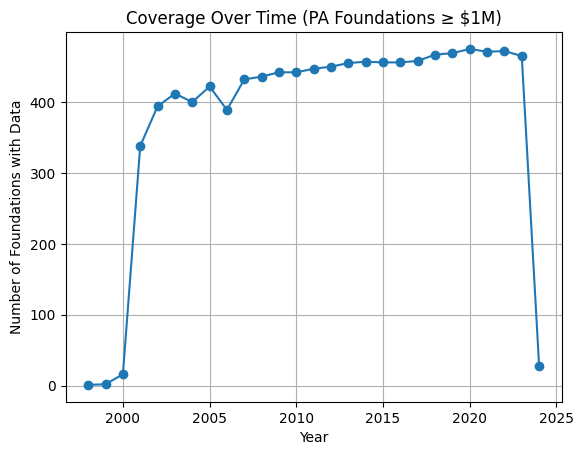

In [73]:
# =========================
# EDA 1: Coverage Over Time
# =========================

# This measures how many foundations (assets >= $1M)
# have usable numeric filings each year.

short_eins = set(shortlist_df["ein"].astype(str))

cov_df = filings_df[filings_df["ein"].astype(str).isin(short_eins)].copy()
cov_df["year"] = cov_df["tax_prd_yr"].apply(safe_int)

coverage_by_year = (
    cov_df.dropna(subset=["year"])
    .groupby("year", as_index=False)
    .agg(
        foundations_with_data=("ein", "nunique")
    )
    .sort_values("year")
)

display(coverage_by_year.tail(15))

plt.figure()
plt.plot(coverage_by_year["year"], coverage_by_year["foundations_with_data"], marker="o")
plt.title("Coverage Over Time (PA Foundations ≥ $1M)")
plt.xlabel("Year")
plt.ylabel("Number of Foundations with Data")
plt.grid(True)
plt.show()


,year,total_assets
7,2005,$0
8,2006,$0
9,2007,$0
10,2008,$0
11,2009,"$35,449,234"
12,2010,"$751,647,744"
13,2011,"$97,786,222,968"
14,2012,"$101,689,866,196"
15,2013,"$114,594,012,958"
16,2014,"$120,241,579,683"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


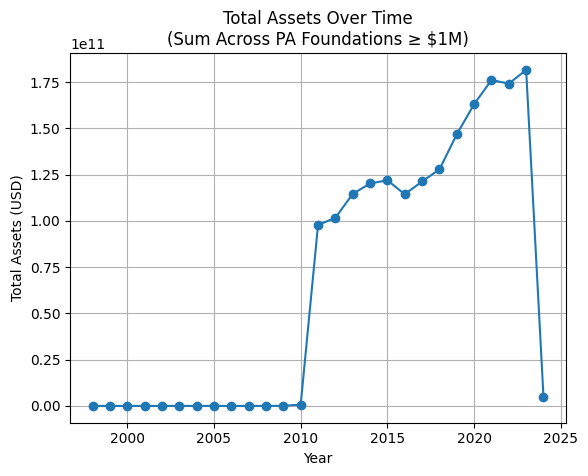

In [84]:
# =========================
# EDA 2: Total Assets Over Time
# =========================

"""
Total assets over time represents the SUM of reported assets
across all PA foundations with assets >= $1M in each year.

Assets typically include:
- Investments
- Cash
- Endowment holdings
- Other financial resources

This reflects the total capital base of large foundations in PA
for each tax year.
"""

assets_by_year = (
    cov_df.dropna(subset=["year"])
    .groupby("year", as_index=False)
    .agg(total_assets=("metric_assets", "sum"))
    .sort_values("year")
)

# Format last few rows nicely
assets_by_year_display = assets_by_year.copy()
assets_by_year_display["total_assets"] = assets_by_year_display["total_assets"].apply(
    lambda x: f"${x:,.0f}" if pd.notna(x) else None
)

display(assets_by_year_display.tail(20))

plt.figure()
plt.plot(assets_by_year["year"], assets_by_year["total_assets"], marker="o")
plt.title("Total Assets Over Time\n(Sum Across PA Foundations ≥ $1M)")
plt.xlabel("Year")
plt.ylabel("Total Assets (USD)")
plt.grid(True)
plt.show()





,year,total_revenue
7,2005,$0
8,2006,$0
9,2007,$0
10,2008,$0
11,2009,"$80,346,443"
12,2010,"$199,623,341"
13,2011,"$41,529,603,712"
14,2012,"$42,278,123,253"
15,2013,"$47,381,786,518"
16,2014,"$48,478,841,871"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


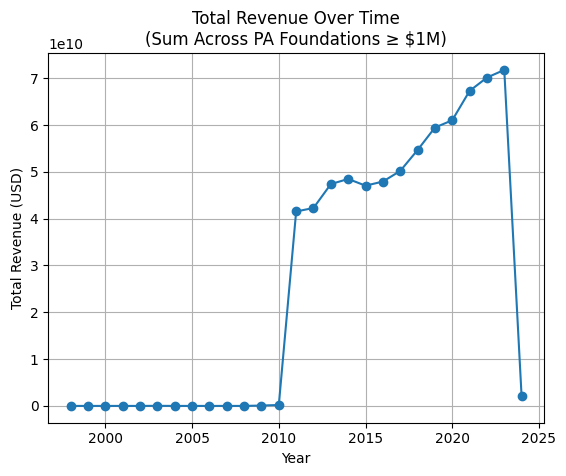

In [85]:
# =========================
# EDA 3: Total Revenue Over Time
# =========================
"""
Total revenue over time represents the SUM of annual revenue
across all PA foundations with assets >= $1M.

Revenue may include:
- Investment income
- Contributions received
- Capital gains
- Other income sources

This shows how much new financial inflow foundations had each year.
"""

revenue_by_year = (
    cov_df.dropna(subset=["year"])
    .groupby("year", as_index=False)
    .agg(total_revenue=("metric_revenue", "sum"))
    .sort_values("year")
)

# Format for display
revenue_by_year_display = revenue_by_year.copy()
revenue_by_year_display["total_revenue"] = revenue_by_year_display["total_revenue"].apply(
    lambda x: f"${x:,.0f}" if pd.notna(x) else None
)

display(revenue_by_year_display.tail(20))

plt.figure()
plt.plot(revenue_by_year["year"], revenue_by_year["total_revenue"], marker="o")
plt.title("Total Revenue Over Time\n(Sum Across PA Foundations ≥ $1M)")
plt.xlabel("Year")
plt.ylabel("Total Revenue (USD)")
plt.grid(True)
plt.show()




In [105]:
# 9F) Map of PA foundations with assets >= $1M (dot size scaled by assets)

!pip -q install pgeocode folium

import math
import numpy as np
import pandas as pd
import pgeocode
import folium

if "shortlist_df" not in globals() or shortlist_df is None or len(shortlist_df) == 0:
    raise ValueError("shortlist_df is missing/empty. Run Section 7B ($1M screen) before Section 9F.")

need_org_cols = {"ein", "org_name", "org_city", "org_state", "zipcode"}
missing = need_org_cols - set(organizations_df.columns)
if missing:
    raise ValueError(f"organizations_df missing required columns: {sorted(list(missing))}")

map_df = shortlist_df.merge(
    organizations_df[["ein", "org_name", "org_city", "org_state", "zipcode"]],
    on="ein",
    how="left",
)

map_df = map_df[map_df["org_state"] == "PA"].copy()

# Clean ZIPs to 5-digit; keep empty as None
map_df["zip5"] = (
    map_df["zipcode"]
    .astype(str)
    .str.extract(r"(\d{5})", expand=False)
)

# Prepare list for pgeocode (must be list-like with same length)
zip_list = map_df["zip5"].fillna("").astype(str).tolist()

nomi = pgeocode.Nominatim("US")
zip_geo = nomi.query_postal_code(zip_list)

# pgeocode returns a DataFrame when given a list; align by position defensively
if not isinstance(zip_geo, pd.DataFrame) or len(zip_geo) != len(map_df):
    print("[WARN] pgeocode returned unexpected shape:", type(zip_geo), getattr(zip_geo, "shape", None))
    # fall back: set lat/lon null and continue
    map_df["lat"] = np.nan
    map_df["lon"] = np.nan
else:
    map_df["lat"] = zip_geo["latitude"].to_numpy()
    map_df["lon"] = zip_geo["longitude"].to_numpy()

# Keep only successfully geocoded rows
map_df_geocoded = map_df.dropna(subset=["lat", "lon", "metric_assets"]).copy()

print("Total shortlist rows:", len(map_df))
print("Rows with usable ZIP5:", int(map_df["zip5"].notna().sum()))
print("Geocoded rows:", len(map_df_geocoded))

display(map_df_geocoded[["org_name", "org_city", "zip5", "metric_assets", "lat", "lon"]].head(10))

def asset_radius(a):
    a = safe_float(a)
    if a is None or not np.isfinite(a) or a <= 0:
        return 3.0
    return float(min(18.0, max(3.0, 2.0 * math.log10(a))))

m = folium.Map(location=[40.9, -77.8], zoom_start=7)

for _, r in map_df_geocoded.iterrows():
    popup_html = (
        f"<b>{r.get('org_name','')}</b><br>"
        f"{r.get('org_city','')}, {r.get('org_state','')}<br>"
        f"EIN: {r.get('ein','')}<br>"
        f"Assets (latest): {safe_float(r.get('metric_assets')):,.0f}"
    )
    folium.CircleMarker(
        location=[float(r["lat"]), float(r["lon"])],
        radius=asset_radius(r["metric_assets"]),
        popup=popup_html,
        fill=True,
    ).add_to(m)

m



Total shortlist rows: 492
Rows with usable ZIP5: 492
Geocoded rows: 492


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,org_name,org_city,zip5,metric_assets,lat,lon
0,National Nurse Led Care Consortium,Philadelphia,19102,21443082.0,39.9489,-75.1661
1,American Bible Society,Philadelphia,19106,769516330.0,39.9474,-75.1473
2,Lawschool Admissions Council Inc,Newtown,18940,276647279.0,40.2630,-74.9555
3,Perseus House Charter School Of Excellence,Erie,16501,6778370.0,42.1260,-80.0860
4,Glaxosmithkline Patient Access Programs Founda...,Philadelphia,19104,73494202.0,39.9597,-75.2024
5,Sun Coast Nursing Centers Inc,Bala Cynwyd,19004,443374948.0,40.0118,-75.2342
6,Institute For Senior Living Of Florida Inc,Bala Cynwyd,19004,115199259.0,40.0118,-75.2342
7,Central Pa Behavorial Health Collaborative Inc,Hollidaysburg,16648,35967820.0,40.4387,-78.3686
8,Southwest Leadership Academy,Philadelphia,19142,11517705.0,39.9223,-75.2338
9,Dorothy And Anthony Bardaro Foundation Inc,Philadelphia,19134,1879467.0,39.9925,-75.1133


In [101]:
# 9G) Top orgs (latest filing) by assets / revenue / expenses

import pandas as pd
import numpy as np

if "latest_df" not in globals() or latest_df is None or len(latest_df) == 0:
    # Build a "latest filing per EIN" view from filings_df (robust)
    tmp = filings_df.copy()
    tmp["tax_prd_int"] = tmp["tax_prd"].apply(safe_int)
    tmp["tax_prd_yr_int"] = tmp["tax_prd_yr"].apply(safe_int)
    tmp = tmp.sort_values(
        by=["ein", "tax_prd_int", "tax_prd_yr_int", "updated"],
        ascending=[True, False, False, False],
        na_position="last",
    )
    latest_df = tmp.groupby("ein", as_index=False).head(1).reset_index(drop=True)
    print("[INFO] latest_df not found; rebuilt from filings_df.")

# Merge in org names + geography
latest_named = latest_df.merge(
    organizations_df[["ein", "org_name", "org_city", "org_state", "ntee_code", "subseccd"]],
    on="ein",
    how="left",
)

# If you want strictly the ≥$1M population, filter to shortlist EINs
if "shortlist_df" in globals() and shortlist_df is not None and len(shortlist_df) > 0:
    short_eins = set(shortlist_df["ein"].astype(str))
    latest_named = latest_named[latest_named["ein"].astype(str).isin(short_eins)].copy()

# Basic sanity prints
print("Latest rows (population):", len(latest_named))
print("Non-null assets %:", float(latest_named["metric_assets"].notna().mean()))
print("Non-null revenue %:", float(latest_named["metric_revenue"].notna().mean()))
print("Non-null expenses %:", float(latest_named["metric_expenses"].notna().mean()))

cols_show = [
    "ein", "org_name", "org_city", "org_state",
    "tax_prd_yr", "formtype", "metric_assets", "metric_revenue", "metric_expenses",
    "pdf_url"
]

top_n = 25


Latest rows (population): 492
Non-null assets %: 1.0
Non-null revenue %: 1.0
Non-null expenses %: 0.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [102]:
print("\nTop by assets (latest filing):")
display(
    latest_named.sort_values("metric_assets", ascending=False)
               .loc[:, [c for c in cols_show if c in latest_named.columns]]
               .head(top_n)
)



Top by assets (latest filing):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,ein,org_name,org_city,org_state,tax_prd_yr,formtype,metric_assets,metric_revenue,metric_expenses,pdf_url
84,231353340,Milton Hershey School & School Trust,Hershey,PA,2023,0,2.423006e+10,8.881517e+08,None,None
371,251423657,Upmc,Pittsburgh,PA,2023,0,1.034813e+10,4.966512e+08,None,https://projects.propublica.org/nonprofits/dow...
73,231352651,Thomas Jefferson University,Philadelphia,PA,2023,0,4.738692e+09,1.666138e+09,None,None
182,232237932,The Childrens Hospital Of Philadelphia Foundation,Philadelphia,PA,2023,0,4.392384e+09,3.775501e+08,None,None
97,231365971,Temple University Of The Commonwealth System O...,Philadelphia,PA,2023,0,3.926300e+09,1.538162e+09,None,None
82,231352683,Swarthmore College,Swarthmore,PA,2023,0,3.463772e+09,2.706682e+08,None,https://projects.propublica.org/nonprofits/dow...
465,621322826,John Templeton Foundation,Conshohocken,PA,2023,2,3.398216e+09,1.757541e+08,None,None
50,231352213,St Lukes Hospital,Bethlehem,PA,2023,0,3.343607e+09,1.425438e+09,None,https://projects.propublica.org/nonprofits/dow...
286,240795445,Lehigh University,Bethlehem,PA,2023,0,3.127360e+09,6.953922e+08,None,https://projects.propublica.org/nonprofits/dow...
65,231352630,Drexel University,Philadelphia,PA,2023,0,2.842409e+09,1.412910e+09,None,None


In [103]:
print("\nTop by revenue (latest filing):")
display(
    latest_named.sort_values("metric_revenue", ascending=False)
               .loc[:, [c for c in cols_show if c in latest_named.columns]]
               .head(top_n))



Top by revenue (latest filing):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,ein,org_name,org_city,org_state,tax_prd_yr,formtype,metric_assets,metric_revenue,metric_expenses,pdf_url
73,231352651,Thomas Jefferson University,Philadelphia,PA,2023,0,4.738692e+09,1.666138e+09,None,None
97,231365971,Temple University Of The Commonwealth System O...,Philadelphia,PA,2023,0,3.926300e+09,1.538162e+09,None,None
91,231365353,Lancaster General Hospital,Lancaster,PA,2023,0,1.182216e+09,1.470319e+09,None,None
401,251778644,Upmc,Pittsburgh,PA,2023,0,9.788040e+08,1.450182e+09,None,None
50,231352213,St Lukes Hospital,Bethlehem,PA,2023,0,3.343607e+09,1.425438e+09,None,https://projects.propublica.org/nonprofits/dow...
65,231352630,Drexel University,Philadelphia,PA,2023,0,2.842409e+09,1.412910e+09,None,None
47,231352204,Reading Hospital,West Reading,PA,2023,0,1.004570e+09,1.383023e+09,None,None
339,250969492,Highmark Health,Pittsburgh,PA,2014,0,1.271827e+09,1.378645e+09,None,https://projects.propublica.org/nonprofits/dow...
221,232766661,Community Behavorial Health,Philadelphia,PA,2023,0,2.558138e+08,1.240095e+09,None,None
229,232810852,Presbyterian Medical Center Of The University ...,Philadelphia,PA,2023,0,9.472222e+08,1.228381e+09,None,None


In [104]:
print("\nTop by expenses (latest filing):")
display(
    latest_named.sort_values("metric_expenses", ascending=False)
               .loc[:, [c for c in cols_show if c in latest_named.columns]]
               .head(top_n))


Top by expenses (latest filing):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,ein,org_name,org_city,org_state,tax_prd_yr,formtype,metric_assets,metric_revenue,metric_expenses,pdf_url
0,10560081,National Nurse Led Care Consortium,Philadelphia,PA,2023,0,2.144308e+07,20589052.0,None,https://projects.propublica.org/nonprofits/dow...
2,131623885,American Bible Society,Philadelphia,PA,2023,0,7.695163e+08,108862481.0,None,None
3,132998164,Lawschool Admissions Council Inc,Newtown,PA,2023,0,2.766473e+08,97577683.0,None,https://projects.propublica.org/nonprofits/dow...
4,200027153,Perseus House Charter School Of Excellence,Erie,PA,2023,0,6.778370e+06,11937000.0,None,https://projects.propublica.org/nonprofits/dow...
5,200031992,Glaxosmithkline Patient Access Programs Founda...,Philadelphia,PA,2023,2,7.349420e+07,902976608.0,None,None
6,200091844,Sun Coast Nursing Centers Inc,Bala Cynwyd,PA,2023,0,4.433749e+08,249532959.0,None,None
7,200904526,Institute For Senior Living Of Florida Inc,Bala Cynwyd,PA,2022,0,1.151993e+08,46275402.0,None,None
8,201646631,Central Pa Behavorial Health Collaborative Inc,Hollidaysburg,PA,2023,0,3.596782e+07,67139020.0,None,None
9,201804098,Southwest Leadership Academy,Philadelphia,PA,2023,0,1.151770e+07,10972225.0,None,None
10,202057509,Dorothy And Anthony Bardaro Foundation Inc,Philadelphia,PA,2023,2,1.879467e+06,-8193.0,None,https://projects.propublica.org/nonprofits/dow...


# Section 10. Appendix

Just didn't wanna delete

In [88]:
"""
# Show all flattened numeric columns in filings_df
fin_cols = [c for c in filings_df.columns if c.startswith("fin_")]
print("Number of financial columns:", len(fin_cols))
display(fin_cols[:50])
"""


Number of financial columns: 186


['fin_tax_prd',
 'fin_tax_prd_yr',
 'fin_formtype',
 'fin_totrevenue',
 'fin_totfuncexpns',
 'fin_totassetsend',
 'fin_totliabend',
 'fin_pct_compnsatncurrofcr',
 'fin_subseccd',
 'fin_initiationfees',
 'fin_grsrcptspublicuse',
 'fin_grsincmembers',
 'fin_grsincother',
 'fin_totcntrbgfts',
 'fin_totprgmrevnue',
 'fin_invstmntinc',
 'fin_txexmptbndsproceeds',
 'fin_royaltsinc',
 'fin_grsrntsreal',
 'fin_grsrntsprsnl',
 'fin_rntlexpnsreal',
 'fin_rntlexpnsprsnl',
 'fin_rntlincreal',
 'fin_rntlincprsnl',
 'fin_netrntlinc',
 'fin_grsalesecur',
 'fin_grsalesothr',
 'fin_cstbasisecur',
 'fin_cstbasisothr',
 'fin_gnlsecur',
 'fin_gnlsothr',
 'fin_netgnls',
 'fin_grsincfndrsng',
 'fin_lessdirfndrsng',
 'fin_netincfndrsng',
 'fin_grsincgaming',
 'fin_lessdirgaming',
 'fin_netincgaming',
 'fin_grsalesinvent',
 'fin_lesscstofgoods',
 'fin_netincsales',
 'fin_miscrevtot11e',
 'fin_compnsatncurrofcr',
 'fin_othrsalwages',
 'fin_payrolltx',
 'fin_profndraising',
 'fin_txexmptbndsend',
 'fin_secrdmrt

In [87]:
print("Revenue missing %:", filings_df["metric_revenue"].isna().mean())
print("Expenses missing %:", filings_df["metric_expenses"].isna().mean())
print("Margin missing %:", filings_df["derived_margin"].isna().mean())

display(
    filings_df[["metric_revenue", "metric_expenses", "derived_margin"]]
    .describe()
)


"""
# =========================
# EDA 4: Median Margin Over Time
# =========================

margin_by_year = (
    cov_df.dropna(subset=["year"])
    .groupby("year", as_index=False)
    .agg(median_margin=("derived_margin", "median"))
    .sort_values("year")
)

display(margin_by_year.tail(20))

plt.figure()
plt.plot(margin_by_year["year"], margin_by_year["median_margin"], marker="o")
plt.title("Median Margin Over Time (Surplus / Revenue)")
plt.xlabel("Year")
plt.ylabel("Median Margin")
plt.grid(True)
plt.show()
"""

Revenue missing %: 0.4161262220501404
Expenses missing %: 1.0
Margin missing %: 1.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,metric_revenue
count,6.032000e+03
mean,1.187881e+08
std,1.860604e+08
min,-4.893260e+07
25%,3.110797e+07
50%,6.013768e+07
75%,1.193647e+08
max,1.840592e+09


'\n# =========================\n# EDA 4: Median Margin Over Time\n# =========================\n\nmargin_by_year = (\n    cov_df.dropna(subset=["year"])\n    .groupby("year", as_index=False)\n    .agg(median_margin=("derived_margin", "median"))\n    .sort_values("year")\n)\n\ndisplay(margin_by_year.tail(20))\n\nplt.figure()\nplt.plot(margin_by_year["year"], margin_by_year["median_margin"], marker="o")\nplt.title("Median Margin Over Time (Surplus / Revenue)")\nplt.xlabel("Year")\nplt.ylabel("Median Margin")\nplt.grid(True)\nplt.show()\n'

In [69]:
"""
# Aggregate trend across all shortlisted foundations by year
short_eins = set(shortlist_df["ein"].astype(str)) if len(shortlist_df) else set()

all_years_short = filings_df[filings_df["ein"].astype(str).isin(short_eins)].copy()
all_years_short["year"] = all_years_short["tax_prd_yr"].apply(safe_int)

agg = (all_years_short
       .dropna(subset=["year"])
       .groupby("year", as_index=False)
       .agg(
           n_foundations=("ein", "nunique"),
           total_assets=("metric_assets", "sum"),
           total_revenue=("metric_revenue", "sum"),
           total_expenses=("metric_expenses", "sum"),
           median_margin=("derived_margin", "median")
       )
       .sort_values("year")
)

display(agg.tail(20))

plt.figure()
plt.plot(agg["year"], agg["n_foundations"], marker="o")
plt.title("Coverage Over Time: # Foundations with Data (Assets ≥ $1M)")
plt.xlabel("Year")
plt.ylabel("# Foundations")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(agg["year"], agg["total_assets"], marker="o")
plt.title("Total Assets Over Time (Assets ≥ $1M foundations)")
plt.xlabel("Year")
plt.ylabel("Total assets (sum)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(agg["year"], agg["median_margin"], marker="o")
plt.title("Median Margin Over Time (Assets ≥ $1M foundations)")
plt.xlabel("Year")
plt.ylabel("Median margin")
plt.grid(True)
plt.show()
"""


'\n# Aggregate trend across all shortlisted foundations by year\nshort_eins = set(shortlist_df["ein"].astype(str)) if len(shortlist_df) else set()\n\nall_years_short = filings_df[filings_df["ein"].astype(str).isin(short_eins)].copy()\nall_years_short["year"] = all_years_short["tax_prd_yr"].apply(safe_int)\n\nagg = (all_years_short\n       .dropna(subset=["year"])\n       .groupby("year", as_index=False)\n       .agg(\n           n_foundations=("ein", "nunique"),\n           total_assets=("metric_assets", "sum"),\n           total_revenue=("metric_revenue", "sum"),\n           total_expenses=("metric_expenses", "sum"),\n           median_margin=("derived_margin", "median")\n       )\n       .sort_values("year")\n)\n\ndisplay(agg.tail(20))\n\nplt.figure()\nplt.plot(agg["year"], agg["n_foundations"], marker="o")\nplt.title("Coverage Over Time: # Foundations with Data (Assets ≥ $1M)")\nplt.xlabel("Year")\nplt.ylabel("# Foundations")\nplt.grid(True)\nplt.show()\n\nplt.figure()\nplt.plot(agg

In [70]:
"""
# Trend Explorer: choose any EIN from shortlist_df
EIN_TO_PLOT = shortlist_df["ein"].iloc[0] if len(shortlist_df) else (filings_df["ein"].iloc[0] if len(filings_df) else "")
print("EIN_TO_PLOT:", EIN_TO_PLOT)

trend_df = filings_df[filings_df["ein"] == EIN_TO_PLOT].copy()
trend_df["year"] = trend_df["tax_prd_yr"].apply(safe_int)
trend_df = trend_df.sort_values("year")

display(trend_df[["ein","year","metric_assets","metric_revenue","metric_expenses","derived_margin","pdf_url"]].tail(15))

plt.figure()
plt.plot(trend_df["year"], trend_df["metric_assets"], marker="o")
plt.title(f"{EIN_TO_PLOT}: Assets Over Time")
plt.xlabel("Year")
plt.ylabel("Assets")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(trend_df["year"], trend_df["metric_revenue"], marker="o", label="Revenue")
plt.plot(trend_df["year"], trend_df["metric_expenses"], marker="o", label="Expenses")
plt.title(f"{EIN_TO_PLOT}: Revenue vs Expenses Over Time")
plt.xlabel("Year")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(trend_df["year"], trend_df["derived_margin"], marker="o")
plt.title(f"{EIN_TO_PLOT}: Margin Over Time")
plt.xlabel("Year")
plt.ylabel("Margin")
plt.grid(True)
plt.show()
"""


'\n# Trend Explorer: choose any EIN from shortlist_df\nEIN_TO_PLOT = shortlist_df["ein"].iloc[0] if len(shortlist_df) else (filings_df["ein"].iloc[0] if len(filings_df) else "")\nprint("EIN_TO_PLOT:", EIN_TO_PLOT)\n\ntrend_df = filings_df[filings_df["ein"] == EIN_TO_PLOT].copy()\ntrend_df["year"] = trend_df["tax_prd_yr"].apply(safe_int)\ntrend_df = trend_df.sort_values("year")\n\ndisplay(trend_df[["ein","year","metric_assets","metric_revenue","metric_expenses","derived_margin","pdf_url"]].tail(15))\n\nplt.figure()\nplt.plot(trend_df["year"], trend_df["metric_assets"], marker="o")\nplt.title(f"{EIN_TO_PLOT}: Assets Over Time")\nplt.xlabel("Year")\nplt.ylabel("Assets")\nplt.grid(True)\nplt.show()\n\nplt.figure()\nplt.plot(trend_df["year"], trend_df["metric_revenue"], marker="o", label="Revenue")\nplt.plot(trend_df["year"], trend_df["metric_expenses"], marker="o", label="Expenses")\nplt.title(f"{EIN_TO_PLOT}: Revenue vs Expenses Over Time")\nplt.xlabel("Year")\nplt.ylabel("USD")\nplt.lege